1. Importer og miljøsjekk

In [1]:
import os
os.environ["TORCH_DISABLE_LEGACY_QUANTIZATION"] = "1"

# Imports
import sys
import time
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Subset

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import InterpolationMode

# Miljøinfo
print("Python:", sys.executable)
print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


Python: c:\Users\henjo\OneDrive\Skrivebord\Studier\Master\Machine Learning\Prosjekt_2\Archive\.venv\Scripts\python.exe
torch: 2.9.0+cpu
torchvision: 0.24.0+cpu
CUDA available: False


device(type='cpu')

2. Konfigurasjon (stier, størrelse, batch, seed)

In [2]:
# Stier, størrelser, batch, seed
DATA_ROOT   = "data"      
IMG_SIZE    = (96, 96)    
BATCH_SIZE  = 8
NUM_WORKERS = 0          
SEED        = 42

torch.manual_seed(SEED)

# Hurtig-kjøring (kan økes/fjernes)
EPOCHS      = 5
PATIENCE    = 2
MAX_TRAIN_BATCHES = 10    # kjør bare noen få batcher per epoke (rask feedback)
MAX_VAL_BATCHES   = 5


3. Transformasjoner (normalisering + maskebehandling)

In [3]:
# Maske: PIL -> Tensor [H,W] (uint8) -> long og skift {1,2,3}->{0,1,2}
class MaskToLongAndShift:
    def __call__(self, mask_pil):
        mask = transforms.PILToTensor()(mask_pil).squeeze(0)  # [H,W], uint8
        return (mask.to(torch.long) - 1)                      # {0,1,2}

img_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),    # [0,255] -> [0,1] float32
])

mask_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE, interpolation=InterpolationMode.NEAREST),
    MaskToLongAndShift(),
])


 4. Last datasett + eksempel

TrainVal: 3680 | Test: 3669
Bilde shape: torch.Size([3, 96, 96])
Maske shape: torch.Size([96, 96])
Unike maskeklasser: tensor([0, 1, 2])


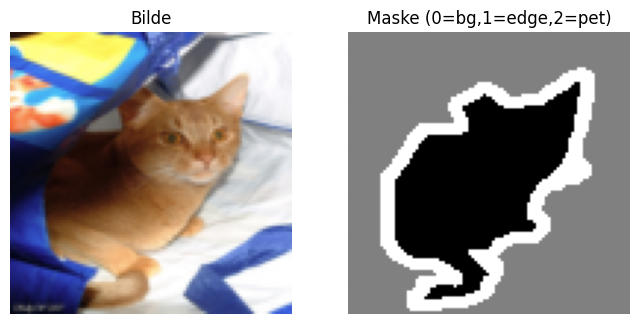

In [4]:
# Last datasett (trainval/test)
trainval_ds = datasets.OxfordIIITPet(
    root=DATA_ROOT,
    split="trainval",
    target_types="segmentation",
    download=True,
    transform=img_transform,
    target_transform=mask_transform,
)

test_ds = datasets.OxfordIIITPet(
    root=DATA_ROOT,
    split="test",
    target_types="segmentation",
    download=True,
    transform=img_transform,
    target_transform=mask_transform,
)

print("TrainVal:", len(trainval_ds), "| Test:", len(test_ds))

# Hent og vis ett eksempel
image, mask = trainval_ds[0]
print("Bilde shape:", image.shape)  # [3,H,W]
print("Maske shape:", mask.shape)   # [H,W]
print("Unike maskeklasser:", torch.unique(mask))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.imshow(image.permute(1,2,0)); ax1.set_title("Bilde"); ax1.axis("off")
ax2.imshow(mask, cmap="gray", vmin=0, vmax=2); ax2.set_title("Maske (0=bg,1=edge,2=pet)"); ax2.axis("off")
plt.show()


5. Visuell overlay og batch-grid

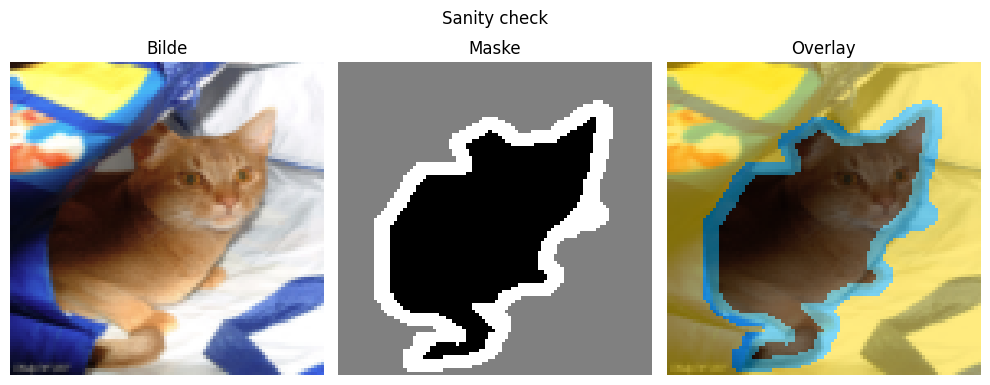

In [5]:
# Farger for overlay
CLASS_NAMES  = ["bg", "edge", "pet"]
CLASS_COLORS = np.array([[0,0,0],[255,215,0],[0,176,240]], dtype=np.uint8)  # svart, gull, blå

def mask_to_rgb(mask: torch.Tensor) -> np.ndarray:
    m = mask.detach().cpu().numpy().astype(np.int64)
    return CLASS_COLORS[m]

def overlay_mask_on_image(image: torch.Tensor, mask: torch.Tensor, alpha=0.5) -> np.ndarray:
    img = (image.detach().cpu().permute(1,2,0).numpy()*255).astype(np.uint8)
    msk = mask_to_rgb(mask)
    return (alpha*msk + (1-alpha)*img).astype(np.uint8)

def show_image_mask(image: torch.Tensor, mask: torch.Tensor, title=""):
    fig, axes = plt.subplots(1,3, figsize=(10,4))
    axes[0].imshow(image.permute(1,2,0)); axes[0].set_title("Bilde"); axes[0].axis("off")
    axes[1].imshow(mask, cmap="gray", vmin=0, vmax=2); axes[1].set_title("Maske"); axes[1].axis("off")
    axes[2].imshow(overlay_mask_on_image(image, mask, alpha=0.5)); axes[2].set_title("Overlay"); axes[2].axis("off")
    if title: fig.suptitle(title)
    plt.tight_layout(); plt.show()

show_image_mask(image, mask, title="Sanity check")


6. Splitt train/val og DataLoaders

In [6]:
# Splitt train/val fra trainval (80/20)
val_size  = int(0.2 * len(trainval_ds))
train_size= len(trainval_ds) - val_size
train_ds, val_ds = random_split(trainval_ds, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Kjapp sjekk på 1 batch
xb, yb = next(iter(train_loader))
print("Batch images:", xb.shape, "| Batch masks:", yb.shape)


Batch images: torch.Size([8, 3, 96, 96]) | Batch masks: torch.Size([8, 96, 96])


7.  Vis en liten batch (bilder + masker)

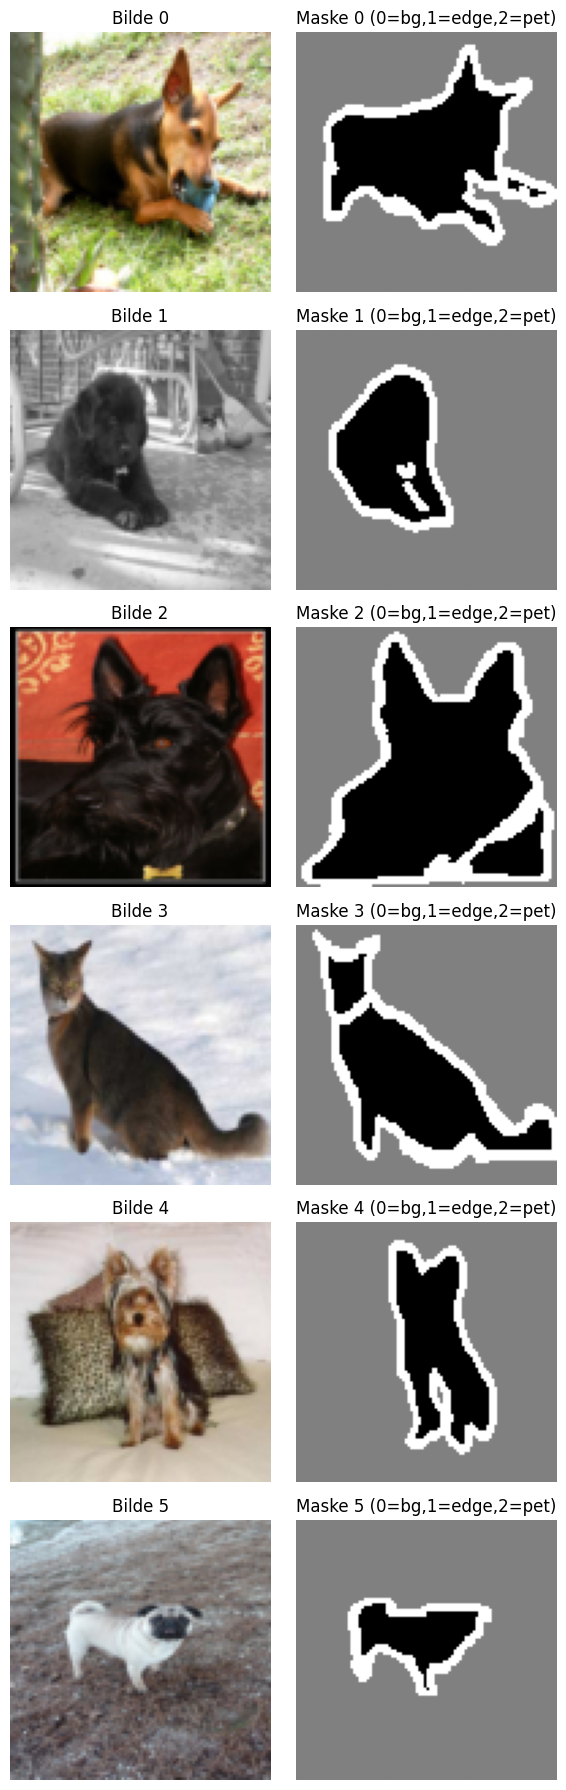

In [7]:


def show_batch(xb, yb, n=8):
    n = min(n, xb.size(0))
    fig, axes = plt.subplots(n, 2, figsize=(6, 3*n))
    for i in range(n):
        axes[i,0].imshow(xb[i].permute(1,2,0))
        axes[i,0].set_title(f"Bilde {i}")
        axes[i,0].axis("off")

        axes[i,1].imshow(yb[i], cmap="gray", vmin=0, vmax=2)
        axes[i,1].set_title(f"Maske {i} (0=bg,1=edge,2=pet)")
        axes[i,1].axis("off")
    plt.tight_layout()
    plt.show()

show_batch(xb, yb, n=6)


8. U-net (liten) + metrikker

In [8]:
# --- Modell ---
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.seq(x)

class UNet(nn.Module):
    def __init__(self, in_ch=3, n_classes=3, base=16):  # base=16 for CPU-fart
        super().__init__()
        self.down1 = ConvBlock(in_ch, base);   self.pool1 = nn.MaxPool2d(2)
        self.down2 = ConvBlock(base, base*2);  self.pool2 = nn.MaxPool2d(2)
        self.down3 = ConvBlock(base*2, base*4);self.pool3 = nn.MaxPool2d(2)
        self.down4 = ConvBlock(base*4, base*8);self.pool4 = nn.MaxPool2d(2)
        self.bridge= ConvBlock(base*8, base*16)
        self.up4   = nn.ConvTranspose2d(base*16, base*8, 2,2); self.dec4 = ConvBlock(base*16, base*8)
        self.up3   = nn.ConvTranspose2d(base*8,  base*4, 2,2); self.dec3 = ConvBlock(base*8,  base*4)
        self.up2   = nn.ConvTranspose2d(base*4,  base*2, 2,2); self.dec2 = ConvBlock(base*4,  base*2)
        self.up1   = nn.ConvTranspose2d(base*2,  base,   2,2); self.dec1 = ConvBlock(base*2,  base)
        self.out   = nn.Conv2d(base, n_classes, 1)

    def forward(self, x):
        d1 = self.down1(x); p1 = self.pool1(d1)
        d2 = self.down2(p1); p2 = self.pool2(d2)
        d3 = self.down3(p2); p3 = self.pool3(d3)
        d4 = self.down4(p3); p4 = self.pool4(d4)
        b  = self.bridge(p4)
        u4 = self.up4(b);  d4 = self.dec4(torch.cat([u4, d4], dim=1))
        u3 = self.up3(d4); d3 = self.dec3(torch.cat([u3, d3], dim=1))
        u2 = self.up2(d3); d2 = self.dec2(torch.cat([u2, d2], dim=1))
        u1 = self.up1(d2); d1 = self.dec1(torch.cat([u1, d1], dim=1))
        return self.out(d1)  # logits [B,3,H,W]

model = UNet(in_ch=3, n_classes=3, base=16).to(device)

# --- Metrikker ---
def per_class_iou(preds, targets, num_classes=3):
    ious = []
    for cls in range(num_classes):
        p = (preds==cls); t=(targets==cls)
        inter = (p & t).sum().item(); union=(p | t).sum().item()
        ious.append(float('nan') if union==0 else inter/union)
    return ious

def mean_iou(preds, targets, num_classes=3):
    vals = [x for x in per_class_iou(preds, targets, num_classes) if x==x]
    return sum(vals)/len(vals) if vals else 0.0

def pixel_accuracy(preds, targets):
    return (preds==targets).float().mean().item()


9. Trening + validering (rask CPU-versjon)

In [9]:

class_weights = torch.tensor([1.0, 1.0, 1.0], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer (bytt mellom Adam og SGD for eksperimenter)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
# opt = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, nesterov=True)

def one_epoch(loader, train=True, max_batches=None):
    if train:
        model.train(True);  context = torch.enable_grad()
    else:
        model.train(False); context = torch.no_grad()

    total_loss = total_miou = total_acc = 0.0
    n_batches = 0

    with context:
        for b_idx, (xb, yb) in enumerate(loader):
            if max_batches is not None and b_idx >= max_batches: break
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)

            if train:
                opt.zero_grad(); loss.backward(); opt.step()

            preds = logits.argmax(1)
            total_loss += loss.item()

            # IoU/acc hver 2. batch i trening (for fart), alltid i validering
            if (not train) or (b_idx % 2 == 0):
                total_miou += mean_iou(preds, yb, 3)
                total_acc  += pixel_accuracy(preds, yb)
                n_batches  += 1

    n = max(1, n_batches)
    return {
        "loss": total_loss / max(1, (max_batches if max_batches is not None else len(loader))),
        "miou": total_miou / n,
        "acc":  total_acc  / n,
    }

best_val, best_state = -1, None
patience_left = PATIENCE
history = []

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    tr  = one_epoch(train_loader, train=True,  max_batches=MAX_TRAIN_BATCHES)
    val = one_epoch(val_loader,   train=False, max_batches=MAX_VAL_BATCHES)

    # Early stopping på val mIoU
    if val["miou"] > best_val:
        best_val = val["miou"]
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        patience_left = PATIENCE
    else:
        patience_left -= 1

    history.append((epoch, tr, val, opt.param_groups[0]["lr"]))
    print(f"Epoch {epoch:02d} | "
          f"train L {tr['loss']:.4f} mIoU {tr['miou']:.3f} acc {tr['acc']:.3f} | "
          f"val   L {val['loss']:.4f} mIoU {val['miou']:.3f} acc {val['acc']:.3f} | "
          f"time {time.time()-t0:.1f}s")

    if patience_left == 0:
        print("Early stopping.")
        break

# Last beste modell før test
if best_state is not None:
    model.load_state_dict({k:v.to(device) for k,v in best_state.items()})


Epoch 01 | train L 1.0389 mIoU 0.276 acc 0.515 | val   L 1.0784 mIoU 0.102 acc 0.306 | time 2.7s
Epoch 02 | train L 0.8960 mIoU 0.347 acc 0.632 | val   L 1.1598 mIoU 0.189 acc 0.568 | time 2.6s
Epoch 03 | train L 0.8366 mIoU 0.361 acc 0.675 | val   L 0.7956 mIoU 0.370 acc 0.692 | time 3.1s
Epoch 04 | train L 0.7650 mIoU 0.414 acc 0.722 | val   L 0.8006 mIoU 0.375 acc 0.692 | time 3.1s
Epoch 05 | train L 0.7372 mIoU 0.410 acc 0.735 | val   L 0.7512 mIoU 0.402 acc 0.716 | time 3.2s


10. Treningskurver og kvalitative prediksjoner

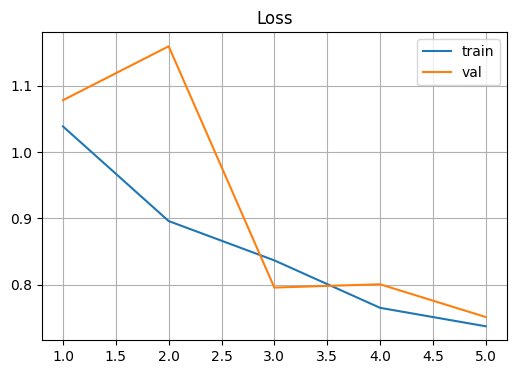

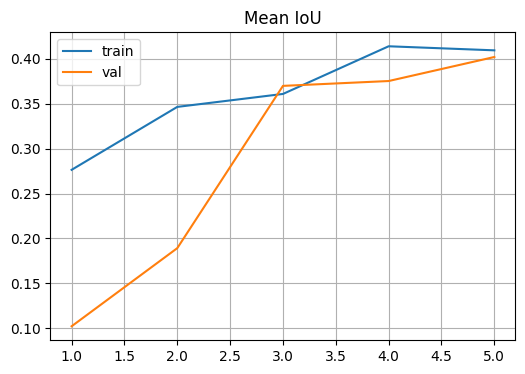

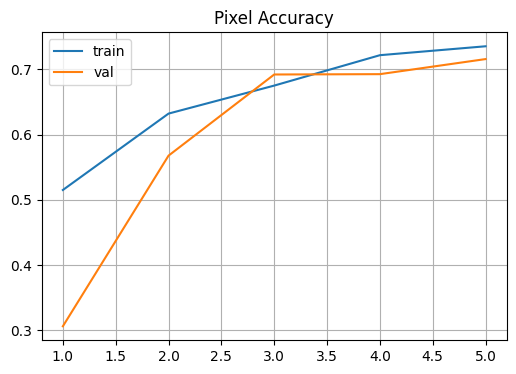

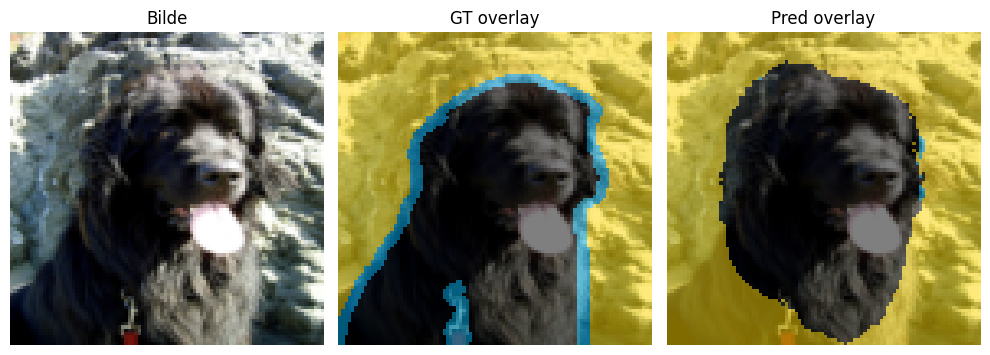

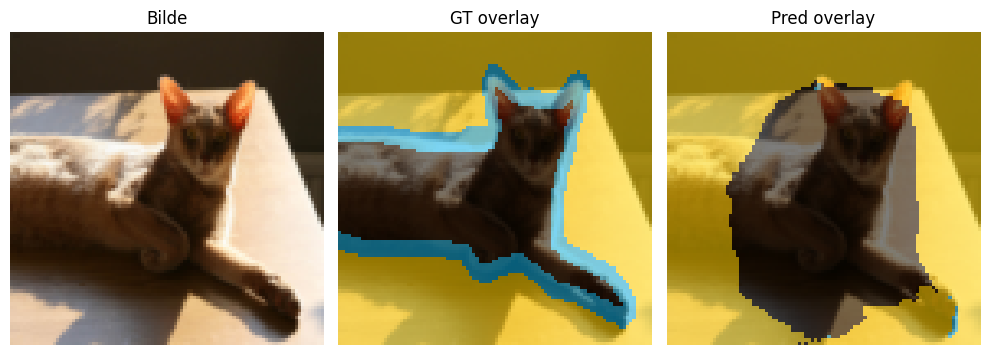

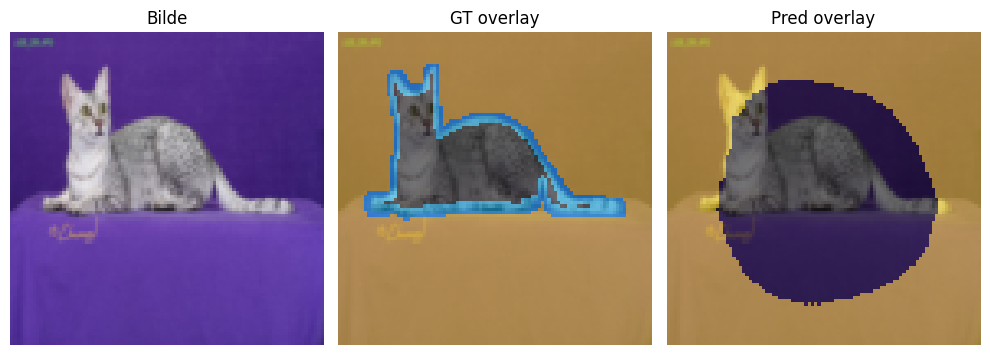

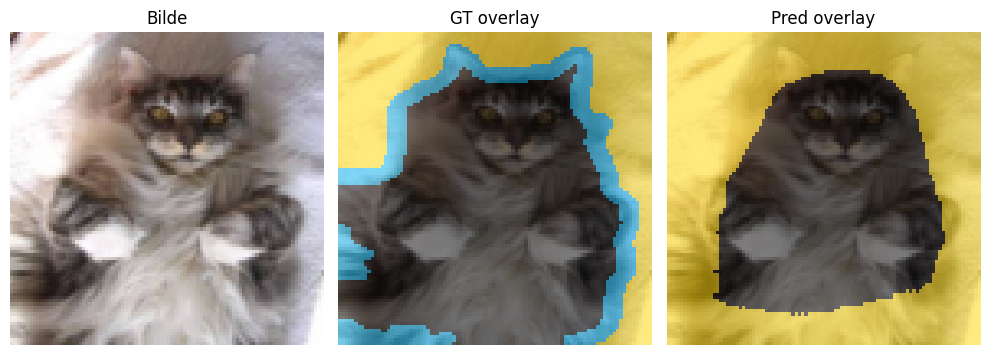

In [10]:
# Plot treningshistorikk
def plot_history(history):
    ep = [e for (e,_,_,_) in history]
    trL = [d["loss"] for (_,d,_,_) in history]; vaL = [d["loss"] for (_,_,d,_) in history]
    trI = [d["miou"] for (_,d,_,_) in history]; vaI = [d["miou"] for (_,_,d,_) in history]
    trA = [d["acc"]  for (_,d,_,_) in history]; vaA = [d["acc"]  for (_,_,d,_) in history]
    plt.figure(figsize=(6,4)); plt.plot(ep,trL,label="train"); plt.plot(ep,vaL,label="val"); plt.title("Loss"); plt.legend(); plt.grid(True); plt.show()
    plt.figure(figsize=(6,4)); plt.plot(ep,trI,label="train"); plt.plot(ep,vaI,label="val"); plt.title("Mean IoU"); plt.legend(); plt.grid(True); plt.show()
    plt.figure(figsize=(6,4)); plt.plot(ep,trA,label="train"); plt.plot(ep,vaA,label="val"); plt.title("Pixel Accuracy"); plt.legend(); plt.grid(True); plt.show()

plot_history(history)

# Kvalitative prediksjoner (GT vs Pred overlay)
@torch.no_grad()
def predict_batch(model, xb, device):
    model.eval()
    return model(xb.to(device)).argmax(1).cpu()

xb, yb = next(iter(val_loader))
preds  = predict_batch(model, xb, device)

n = min(4, xb.size(0))
for i in range(n):
    fig, axes = plt.subplots(1,3, figsize=(10,4))
    axes[0].imshow(xb[i].permute(1,2,0)); axes[0].set_title("Bilde"); axes[0].axis("off")
    axes[1].imshow(overlay_mask_on_image(xb[i], yb[i], 0.5)); axes[1].set_title("GT overlay"); axes[1].axis("off")
    axes[2].imshow(overlay_mask_on_image(xb[i], preds[i], 0.5)); axes[2].set_title("Pred overlay"); axes[2].axis("off")
    plt.tight_layout(); plt.show()


11. Test, mIoU per klasse og 95 % konfidensintervall

TEST: {'loss': 0.7585041763216323, 'miou': 0.39439554401675037, 'acc': 0.7113490170902677, 'per_image_mious': [0.3505433153605919, 0.39716153595951353, 0.4147044531789292, 0.35196990761392183, 0.34314005406114156, 0.340325136737547, 0.390443069873545, 0.3660737267811281, 0.35625920036213676, 0.3957754160352472, 0.36917067901613937, 0.32348429226687275, 0.3987441254752553, 0.3812969625604476, 0.38111390282408264, 0.38155276824274337, 0.3433620532091111, 0.3893380897233692, 0.4041755317592121, 0.3614808310809478, 0.4016206970218224, 0.41098022443768417, 0.38732010815952383, 0.37367887159163843, 0.35417011141221405, 0.41220985931463017, 0.3661203402971345, 0.38241355488801343, 0.38339750502965936, 0.4360605366649055, 0.3670361591735598, 0.3337120603488199, 0.37101970109815535, 0.359979754585702, 0.3836145316109098, 0.38817956973473144, 0.37802644895809695, 0.3583829846163562, 0.384341675540014, 0.4240296582838077, 0.3958466820668484, 0.4259358201108468, 0.3822185929244777, 0.3917031563128

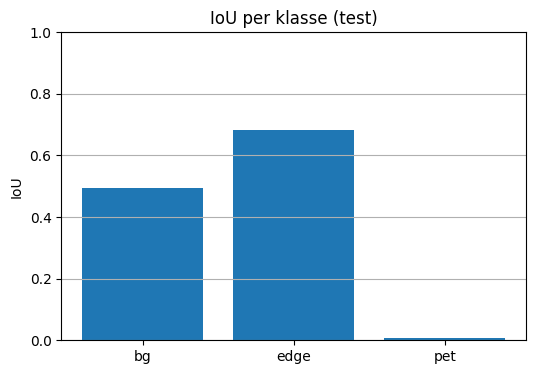

mIoU (test) = 0.394  [95% CI: 0.392, 0.397]


In [11]:
@torch.no_grad()
def evaluate(loader):
    model.eval()
    losses, mious, accs = [], [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb).item()
        preds = logits.argmax(1)
        losses.append(loss)
        mious.append(mean_iou(preds, yb, 3))
        accs.append(pixel_accuracy(preds, yb))
    return {"loss": float(np.mean(losses)),
            "miou": float(np.mean(mious)),
            "acc":  float(np.mean(accs)),
            "per_image_mious": mious}

test_metrics = evaluate(test_loader)
print("TEST:", test_metrics)

# mIoU per klasse (globalt)
def accumulate_intersection_union(loader, model, num_classes=3):
    inter = np.zeros(num_classes, dtype=np.int64)
    union = np.zeros(num_classes, dtype=np.int64)
    with torch.no_grad():
        model.eval()
        for xb, yb in loader:
            xb = xb.to(device); yb = yb.to(device)
            preds = model(xb).argmax(1)
            for c in range(num_classes):
                p = (preds==c); t=(yb==c)
                inter[c] += (p & t).sum().item()
                union[c] += (p | t).sum().item()
    iou = np.where(union>0, inter/union, np.nan)
    return iou

class_iou = accumulate_intersection_union(test_loader, model, 3)
print("Per-class IoU:", class_iou)

plt.figure(figsize=(6,4))
x = np.arange(len(CLASS_NAMES))
plt.bar(x, class_iou); plt.xticks(x, CLASS_NAMES); plt.ylim(0,1); plt.ylabel("IoU"); plt.title("IoU per klasse (test)")
plt.grid(True, axis='y'); plt.show()

# 95% Bootstrap CI for mIoU
def bootstrap_ci(values, n_boot=2000, alpha=0.05, seed=42):
    rng = np.random.default_rng(seed)
    vals = np.asarray(values, dtype=float)
    boots = [np.mean(rng.choice(vals, size=len(vals), replace=True)) for _ in range(n_boot)]
    lo, hi = np.percentile(boots, [100*(alpha/2), 100*(1-alpha/2)])
    return float(np.mean(vals)), float(lo), float(hi)

miou_mean, miou_lo, miou_hi = bootstrap_ci(test_metrics["per_image_mious"])
print(f"mIoU (test) = {miou_mean:.3f}  [95% CI: {miou_lo:.3f}, {miou_hi:.3f}]")
